In [236]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('default')           # 默认风格
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [109]:
df_invest = pd.read_excel(r'作業一數據.xlsx', sheet_name='資產配置數據集合', index_col=0)
df_invest = df_invest.iloc[:, :4]
d_start = pd.to_datetime('2013-12-01')
d_end = pd.to_datetime('2024-09-30')
df_invest = df_invest.query('index > @d_start and index <= @d_end')

In [271]:
# 相關係數
df_corr = df_invest.iloc[3:, :].pct_change().corr()

In [276]:
df_corr

,富达基金_环球科技基金_净值,纳斯达克100指数,美国国债_摊余成本法复利计算净值,3081.HK價值黃金基金_淨值
富达基金_环球科技基金_净值,1.000000,0.832460,0.016606,-0.110759
纳斯达克100指数,0.832460,1.000000,-0.002656,0.066317
美国国债_摊余成本法复利计算净值,0.016606,-0.002656,1.000000,0.000735
3081.HK價值黃金基金_淨值,-0.110759,0.066317,0.000735,1.000000


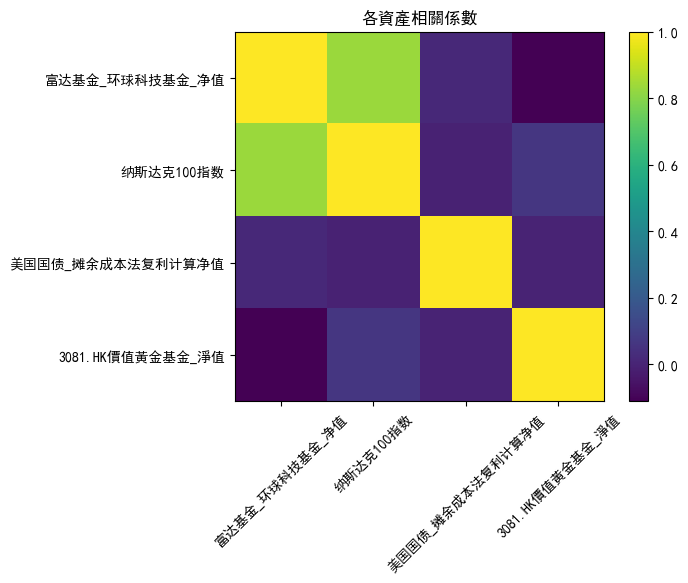

In [283]:
plt.figure()
plt.imshow(df_corr)
plt.xticks([0,1,2,3], df_corr.columns.tolist(), rotation=45)
plt.yticks([0,1,2,3], df_corr.index.tolist())
plt.title('各資產相關係數')
plt.colorbar()
plt.show()

In [162]:
# 进行正態檢驗  數據量太少了, 正態檢驗就算了
import scipy.stats as scs
def normality_test(array):
    print('Norm test p-value %14.3f' % scs.normaltest(array)[1])
for c in df_invest.columns:
    print('\nResults for {}'.format(c))
    print('-'*32)
    log_data = np.array(df_invest[c].pct_change().dropna())
    normality_test(log_data)


Results for 富达基金_环球科技基金_净值
--------------------------------
Norm test p-value          0.489

Results for 纳斯达克100指数
--------------------------------
Norm test p-value          0.475

Results for 美国国债_摊余成本法复利计算净值
--------------------------------
Norm test p-value          0.059

Results for 3081.HK價值黃金基金_淨值
--------------------------------
Norm test p-value          0.331


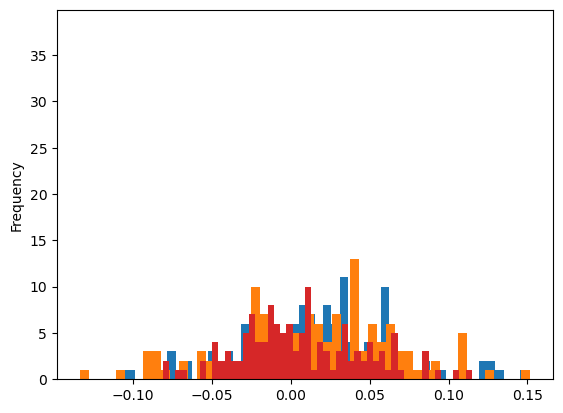

In [163]:
for c in df_invest.columns:
    df_invest[c].pct_change().plot(kind='hist', bins=50)

In [205]:
# 計算組合年化波動率
def get_std(weight, cov_pctchange):
    xx = np.dot(weight, cov_pctchange)
    xx = np.dot(weight, xx)
    return np.sqrt(xx) * np.sqrt(12)

In [229]:
# 計算組合預期收益率
s_return = (df_invest.iloc[-1, :] / df_invest.iloc[0, :]) ** (12 / (df_invest.shape[0]-1)) - 1
s_return = s_return.values
def get_return(weight, s_return):
    return np.sum(weight * s_return)

In [234]:
cov_pctchange = df_invest.pct_change().dropna().cov().values
df_weights['年化波動率'] = None
df_weights['預期年化收益率'] = None
for i in tqdm(range(df_weights.shape[0])):
    weight = df_weights.iloc[i, :df_invest.shape[1]].values
    df_weights.loc[df_weights.index[i], '年化波動率'] = get_std(weight, cov_pctchange)
    df_weights.loc[df_weights.index[i], '預期年化收益率'] = get_return(weight, s_return) 

100%|██████████| 1000000/1000000 [04:30<00:00, 3702.29it/s]


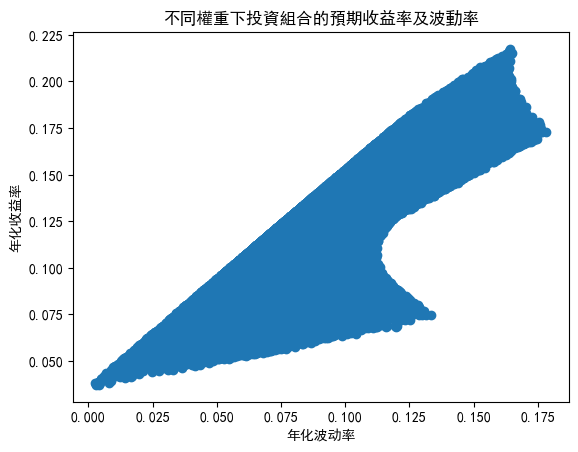

In [270]:
plt.figure()
plt.scatter(df_weights['年化波動率'], df_weights['預期年化收益率'])
plt.xlabel('年化波动率')
plt.ylabel('年化收益率')
plt.title('不同權重下投資組合的預期收益率及波動率')
plt.show()

In [244]:
# 當預期年化收益率大於10%時的年華波動率
std_min = df_weights.loc[df_weights['預期年化收益率']>=0.1]['年化波動率'].min()
df_weights.loc[df_weights['年化波動率']==std_min]

,富达基金_环球科技基金_净值,纳斯达克100指数,美国国债_摊余成本法复利计算净值,3081.HK價值黃金基金_淨值,年化波動率,預期年化收益率
610376,0.320882,0.003387,0.537968,0.137763,0.055162,0.100017


In [ ]:
# 投資組合淨值
s_portfolio_nav = ((df_invest * 100 / df_invest.iloc[0, :]) * df_weights.loc[df_weights['年化波動率']==std_min].values[0][:4]).sum(axis=1)

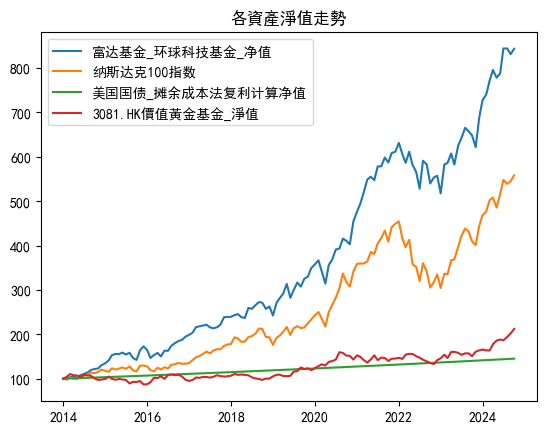

In [269]:
plt.figure()
for c in df_invest.columns:
    plt.plot(df_invest.index, df_invest[c]*100/df_invest[c][0], label=c)
# plt.plot(s_portfolio_nav.index, s_portfolio_nav, label='資產組合淨值', linewidth=3, linestyle=':')
plt.legend()
plt.title('各資產淨值走勢')
plt.show()

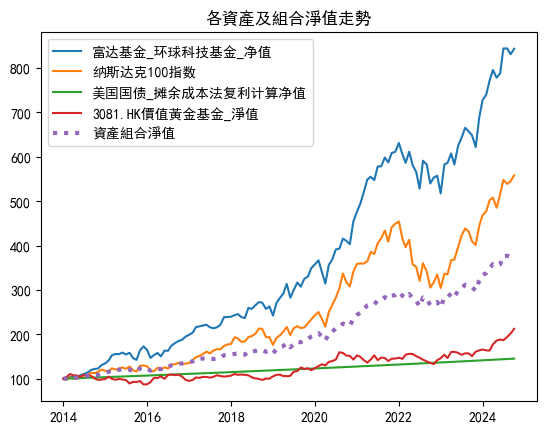

In [267]:
# 各資產走勢圖

plt.figure()
for c in df_invest.columns:
    plt.plot(df_invest.index, df_invest[c]*100/df_invest[c][0], label=c)
plt.plot(s_portfolio_nav.index, s_portfolio_nav, label='資產組合淨值', linewidth=3, linestyle=':')
plt.legend()
plt.title('各資產及組合淨值走勢')
plt.show()

In [301]:
# 回測年化波動率
_sigma = s_portfolio_nav.pct_change().std()*np.sqrt(12)
print('回測年化波動率:{:.2%}'.format(_sigma))

回測年化波動率:9.23%


In [302]:
# 回測年化收益率
_rp = (s_portfolio_nav.iloc[-1] / s_portfolio_nav.iloc[0]) ** (12 / (len(s_portfolio_nav) - 1)) - 1
print('回測年化收益率:{:.2%}'.format(_rp))

回測年化收益率:13.22%


In [303]:
# 夏普比率計算
print('無風險收益率按照3.5%計算,投資組合的夏普比率為:{:.2f}'.format((_rp - 0.035)/_sigma))

無風險收益率按照3.5%計算,投資組合的夏普比率為:1.05
